In [ ]:
!pip3 install -r requirements.txt

In [52]:
import os
# os.environ['MUSDB_PATH'] = '/root/MUSDB18/MUSDB18-7' # <- change to local dataset path

import sys
sys.path.append(os.path.abspath('../'))

In [53]:
import musdb

mus_train = musdb.DB(subsets="train", split='train')
mus_valid = musdb.DB(subsets="train", split='valid')

In [54]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from torchmetrics.functional import signal_distortion_ratio
from torchinfo import summary
import musdb
import torch
import transforms
import utils
from mdensenet import MDenseNet

import tqdm
torch.cuda.device_count()

1

In [55]:
print('sampling tracks')
rng = np.random.default_rng()
train_size, valid_size = 80, 14
sample_length_seconds = 5
mixtures_train, targets_train = utils.sample_musdb_tracks(mus_train.tracks[:train_size], sample_length_seconds, sample_targets='vocals', rng=rng)
mixtures_valid, targets_valid = utils.sample_musdb_tracks(mus_valid.tracks[:valid_size], sample_length_seconds, sample_targets='vocals', rng=rng)
print('calculating stft')
mixtures_stft, targets_stft = transforms.stft(torch.tensor(mixtures_train, dtype=torch.float)), transforms.stft(torch.tensor(targets_train, dtype=torch.float))
mixtures_stft_valid, targets_stft_valid = transforms.stft(torch.tensor(mixtures_valid, dtype=torch.float)), transforms.stft(torch.tensor(targets_valid, dtype=torch.float))


sampling tracks
calculating stft


In [56]:
class STFTDataset(torch.utils.data.Dataset):
    def __init__(self, mixture_stft, target_stft):
        self.mixture_stft = mixture_stft
        self.target_stft = target_stft

    def __len__(self):
        return len(self.mixture_stft)

    def __getitem__(self, idx):
        return self.mixture_stft[idx], self.target_stft[idx]

In [57]:
batch_size = 8
valid_batch_size = 16

training_data = STFTDataset(mixtures_stft, targets_stft)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

valid_data = STFTDataset(mixtures_stft_valid, targets_stft_valid)
valid_loader = DataLoader(valid_data, batch_size=valid_batch_size)

In [58]:
in_channels, num_features = 2, 32

growth_rate = [12,12,12,12,12,12,12]
kernel_size = 3

dilated = [True] * len(growth_rate)
norm = [True] * len(growth_rate)
nonlinear = [True] * len(growth_rate)
depth = [4,4,4,4,4,4,4]

growth_rate_final=4
kernel_size_final=3
depth_final=2
max_bin=2049
dilated_final=True
norm_final=True
nonlinear_final=True

model = MDenseNet(in_channels, num_features, growth_rate, kernel_size, dilated=dilated, norm=norm, nonlinear=nonlinear, depth=depth,
    growth_rate_final=growth_rate_final, kernel_size_final=kernel_size_final, depth_final=depth_final,
    dilated_final=dilated_final, norm_final=norm_final, nonlinear_final=nonlinear_final,
    max_bin=max_bin)
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

summary(model)


Layer (type:depth-idx)                                       Param #
MDenseNet                                                    --
├─MDenseNetBackbone: 1-1                                     --
│    └─Conv2d: 2-1                                           608
│    └─Encoder: 2-2                                          --
│    │    └─Sequential: 3-1                                  48,208
│    └─DenseBlock: 2-3                                       --
│    │    └─Sequential: 3-2                                  13,176
│    └─Decoder: 2-4                                          --
│    │    └─Sequential: 3-3                                  56,988
├─ReLU: 1-2                                                  --
├─DenseBlock: 1-3                                            --
│    └─Sequential: 2-5                                       --
│    │    └─ConvBlock2d: 3-4                                 896
│    │    └─ConvBlock2d: 3-5                                 156
├─BatchNorm2d: 1-4  

In [59]:
epochs = 10
train_losses, valid_losses = [], []

for epoch in tqdm.tqdm(range(epochs)):

    model.train()
    train_loss = 0.
    for i, (mixture, target) in enumerate(train_loader):

        optimizer.zero_grad()
        # magnitude, phase = torch.abs(mixture), torch.angle(mixture)
        # outputs = model(magnitude) * torch.exp(1j * phase)
        outputs = model(torch.abs(mixture))

        loss = loss_fn(outputs, torch.abs(target))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()


    model.eval()
    valid_loss = 0.
    with torch.no_grad():
      for i, (mixture, target) in enumerate(valid_loader):
        outputs = model(torch.abs(mixture))

        loss = loss_fn(outputs, torch.abs(target))
        valid_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'epoch {epoch}: train loss {train_loss:3f} valid loss {valid_loss:3f}')

model_path = f'trained_model_epoch_{epochs}.pt'
torch.save(model.cpu().state_dict(), model_path)
print(f'Done, model saved at {model_path}')

 10%|█         | 1/10 [00:11<01:45, 11.71s/it]

epoch 0: train loss 5.458902 valid loss 3.880842


 20%|██        | 2/10 [00:23<01:33, 11.68s/it]

epoch 1: train loss 4.797487 valid loss 3.377688


 30%|███       | 3/10 [00:35<01:21, 11.66s/it]

epoch 2: train loss 4.509888 valid loss 2.815324


 40%|████      | 4/10 [00:46<01:09, 11.64s/it]

epoch 3: train loss 4.288503 valid loss 2.789905


 50%|█████     | 5/10 [00:58<00:58, 11.63s/it]

epoch 4: train loss 4.062422 valid loss 2.386231


 60%|██████    | 6/10 [01:09<00:46, 11.62s/it]

epoch 5: train loss 3.952276 valid loss 2.718709


 70%|███████   | 7/10 [01:21<00:34, 11.61s/it]

epoch 6: train loss 3.730111 valid loss 2.624918


 80%|████████  | 8/10 [01:33<00:23, 11.61s/it]

epoch 7: train loss 3.573430 valid loss 2.348395


 90%|█████████ | 9/10 [01:44<00:11, 11.61s/it]

epoch 8: train loss 3.381926 valid loss 2.212503


100%|██████████| 10/10 [01:56<00:00, 11.62s/it]

epoch 9: train loss 3.195724 valid loss 2.273990
Done, model saved at trained_model_epoch_10.pt


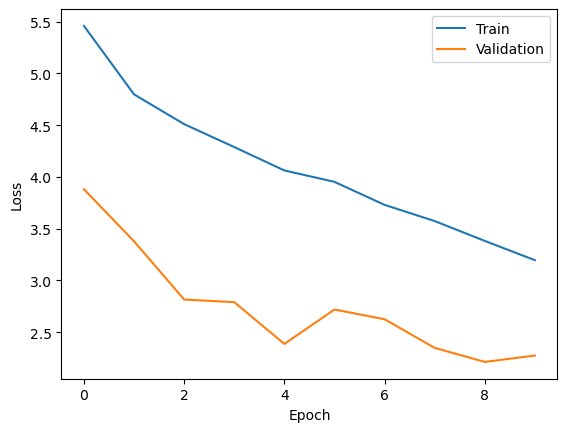

In [67]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [61]:
torch.save(model.get_config(), 'model_config.pt')

In [62]:
# model_2 = MDenseNet.build_model('model_config.pt')
# model_2.load_state_dict(torch.load('trained_model_epoch_100.pt'))

In [63]:
sdrs = []
model.cuda()
preds, mixtures, targets = [], [], []
with torch.no_grad():
      for i, (mixture, target) in enumerate(valid_loader):
        magnitude, phase = torch.abs(mixture), torch.angle(mixture)
        outputs = model(magnitude) * torch.exp(1j * phase)
        pred_valid = transforms.istft(outputs)
        mixture_valid = transforms.istft(mixture)
        target_valid = transforms.istft(target)
        preds.append(pred_valid)
        mixtures.append(mixture_valid)
        targets.append(target_valid)
        sdr = signal_distortion_ratio(
            pred_valid,
            target_valid, load_diag=1e-12).cpu().numpy().flatten()
        sdrs.append(sdr)

preds = torch.cat(preds).cpu().numpy()
mixtures = torch.cat(mixtures).cpu().numpy()
targets = torch.cat(targets).cpu().numpy()
final_sdr = np.concatenate(sdrs).mean()
print(f'final sdr: {final_sdr}')

final sdr: -inf


In [ ]:
import IPython.display as ipd
ipd.Audio(preds[-1], rate=44100)

In [ ]:
ipd.Audio(mixtures[-1], rate=44100)

In [ ]:
ipd.Audio(targets[-1], rate=44100)

In [116]:
import scipy.io.wavfile

for i in tqdm.tqdm(range(len(preds))):
  scipy.io.wavfile.write(f'sample_output/preds/{i}.wav', 44100, preds[i].T)
  scipy.io.wavfile.write(f'sample_output/mixtures/{i}.wav', 44100, mixtures[i].T)
  scipy.io.wavfile.write(f'sample_output/targets/{i}.wav', 44100, targets[i].T)


100%|██████████| 14/14 [00:00<00:00, 63.66it/s]


In [68]:
del preds, mixtures, targets

In [ ]:
!zip -r sample_output.zip sample_output